In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer
from tf_lassonet.model import LassoNet
from tf_lassonet.path import LassoPath
import seaborn as sbs
sbs.set()

2022-06-08 18:34:22.238875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 18:34:22.238890: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load the dataset

Only the numbers 5 and 6 are selected

In [3]:
BATCH_SIZE = 2048

(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def keep_5_and_6(x, y):
    if y == 5 or y == 6:
        return True
    else:
        return False


def to_binary(x, y):
    if y== 5:
        return x, 0
    else:
        return x, 1

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label


ds_train = (
    ds_train.filter(keep_5_and_6)
    .map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(to_binary)
    .cache()
    .shuffle(ds_info.splits["train"].num_examples)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

ds_test = (
    ds_test.filter(keep_5_and_6)
    .map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(to_binary)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

2022-06-08 18:34:24.022308: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-08 18:34:24.022327: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-08 18:34:24.022337: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lolo): /proc/driver/nvidia/version does not exist
2022-06-08 18:34:24.022632: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Create our model

In [4]:
model = Sequential(
    [
        InputLayer((28, 28, 1)),        
        Conv2D(5, (3,3), activation="relu", name="conv"),
        Flatten(),        
        Dense(2, name="layer4"),
    ]
)

In [5]:
path = LassoPath(
    model, 
    n_iters_init=10, 
    patience_init=3, 
    
    n_iters_path=6, 
    patience_path=2, 
    M=30,

    lambda_start='auto',
    path_multiplier=1.01
)
path.lassonet.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


In [6]:
h = path.fit(ds_train, ds_test, verbose=True)

0it [00:00, ?it/s]

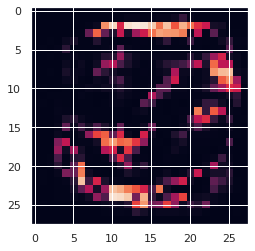

In [9]:
import numpy as np 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots()
ax.imshow(path.compute_feature_importances().reshape(28, 28))
    

array([<AxesSubplot:xlabel='number of selected features'>,
       <AxesSubplot:xlabel='lambda', ylabel='score'>,
       <AxesSubplot:xlabel='lambda', ylabel='number of selected features'>],
      dtype=object)

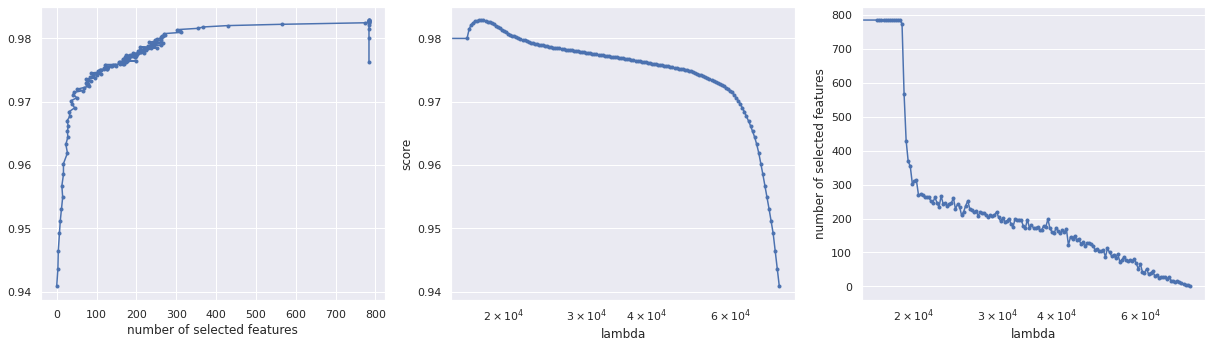

In [10]:
from tf_lassonet.graphics import plot_path
from sklearn.metrics import accuracy_score
plot_path(path.lassonet, h, ds_test, 
          score_function=tf.keras.metrics.SparseCategoricalAccuracy(),
         figsize=(17, 5))